# Unsupervised Learning for Fraud Detection
## César Muro Cabral


In this project, we employ the clustering methods K-Means and DBSCAN to detect fraud.  
  
We look at bank payment transaction data. The financial transactions are categorized by type of expense, as well as the amount spent. Moreover, some client characteristics available such as age group and gender. Some of the transactions are labelled as fraud; we'll treat these labels as given and will use those to validate the results.    
  
We employ two clustering models: minibatchkmeans and dbscan.   
  
For kmeans, we construct a pipeline with two steps: a preprocessor step to transform the data and the model. We find the best hyperparameters using the library optuna.    
  
For the dbscan, we initialize the model setting the maximum distance between two samples to 0.9 and the minimum observations in the clusters to 10.   

## Exploring data analysis

The fields or columns of the dataset are:

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("banksim.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7200 non-null   int64  
 1   age         7200 non-null   object 
 2   gender      7200 non-null   object 
 3   category    7200 non-null   object 
 4   amount      7200 non-null   float64
 5   fraud       7200 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 337.6+ KB


In [30]:
df.head(15)

,Unnamed: 0,age,gender,category,amount,fraud
0,171915,3,F,es_transportation,49.71,0
1,426989,4,F,es_health,39.29,0
2,310539,3,F,es_transportation,18.76,0
3,215216,4,M,es_transportation,13.95,0
4,569244,2,M,es_transportation,49.87,0
5,153631,4,F,es_hyper,57.82,0
6,290621,5,F,es_transportation,27.26,0
7,78537,2,F,es_transportation,7.61,0
8,56239,4,M,es_transportation,42.01,0
9,562564,2,F,es_transportation,21.08,0


Let's visualize the distribution of each field and check whether there are any obvious patterns for the clients.  
  
The different categories are:

In [44]:
df['category'].value_counts()

es_transportation        5975
es_food                   294
es_health                 243
es_wellnessandbeauty      198
es_fashion                 97
es_barsandrestaurants      89
es_hyper                   80
es_sportsandtoys           76
es_tech                    39
es_hotelservices           31
es_home                    24
es_travel                  18
es_contents                13
es_leisure                 13
es_otherservices           10
Name: category, dtype: int64

where their distribution according if they are fraudulent is:

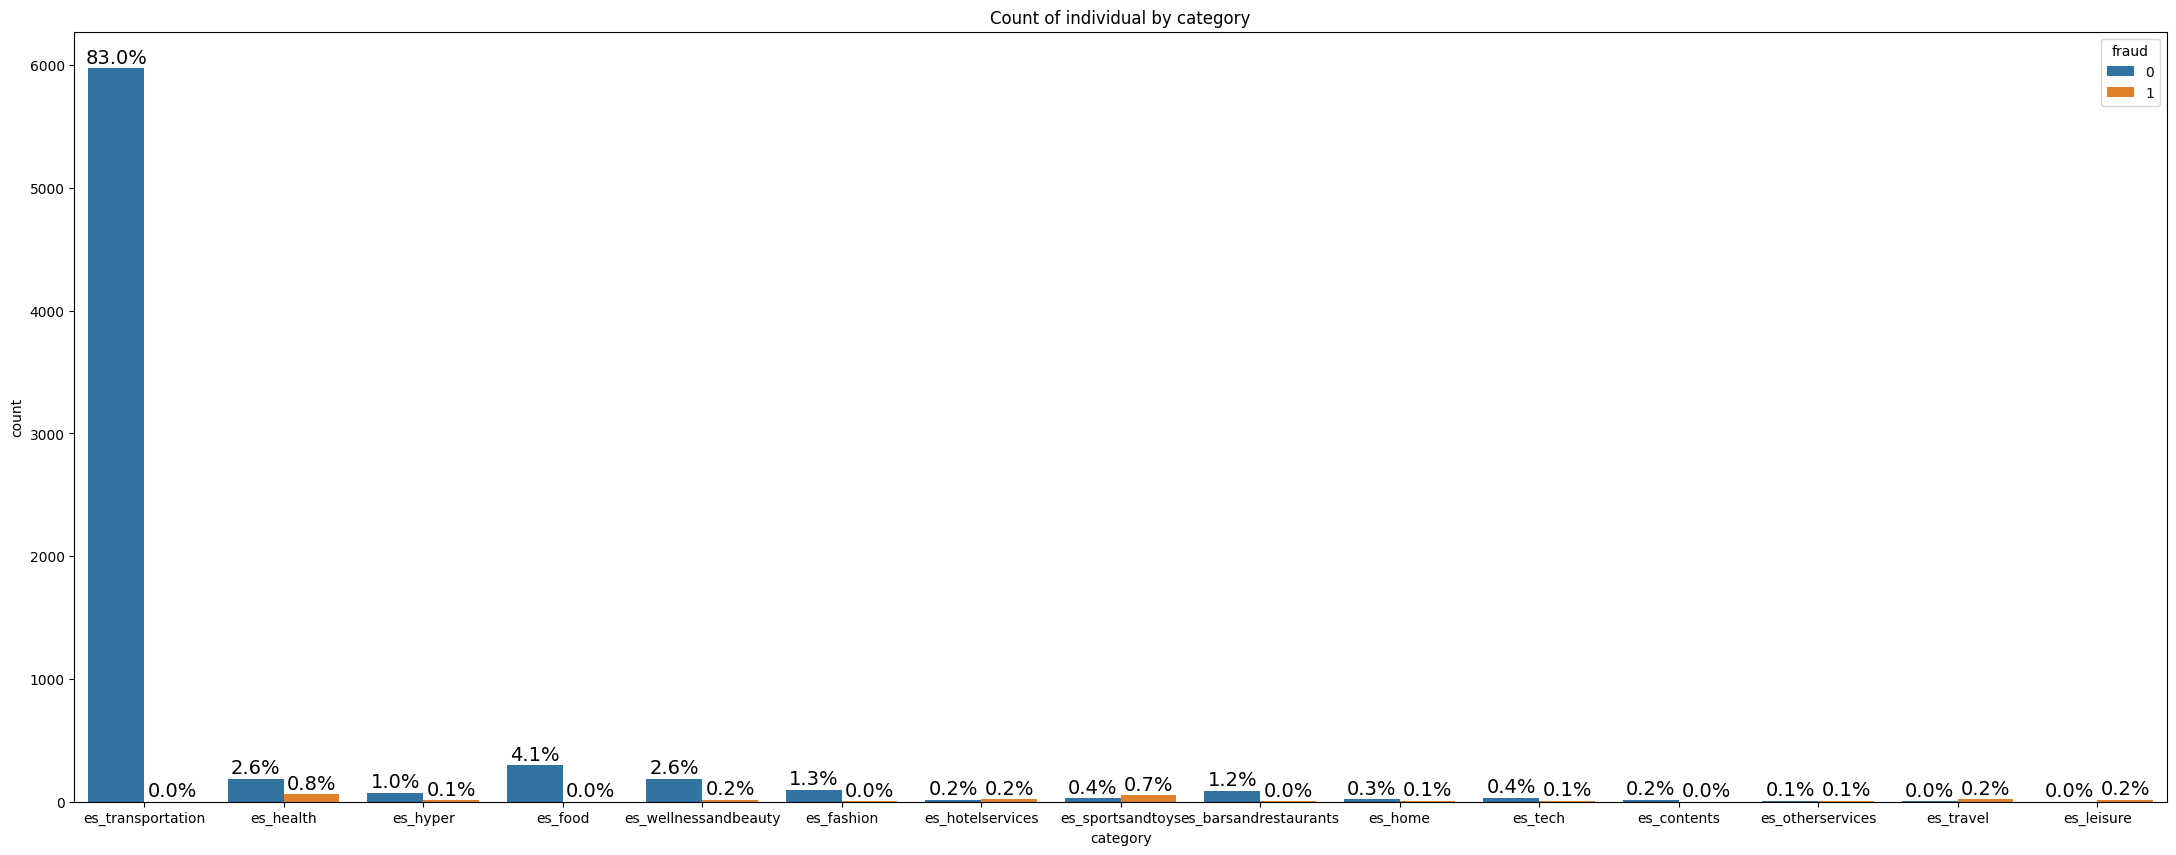

In [17]:
total = len(df)
fig, axes = plt.subplots(1,1,figsize=(27,10))
sns.countplot(x='category', hue='fraud', data=df, ax=axes)
axes.set(title="Count of individual by category", xlabel='category')
for p in axes.patches:
    percentage=f'{100*p.get_height()/total:.1f}%\n'
    x=p.get_x()+p.get_width()/2
    y=p.get_height()
    axes.annotate(percentage,(x,y),ha='center',va='center',fontsize=14)

We observe that the category "es_sports and toys" presents more fraudelent cases.  
  
Now, let us inspect by gender:  

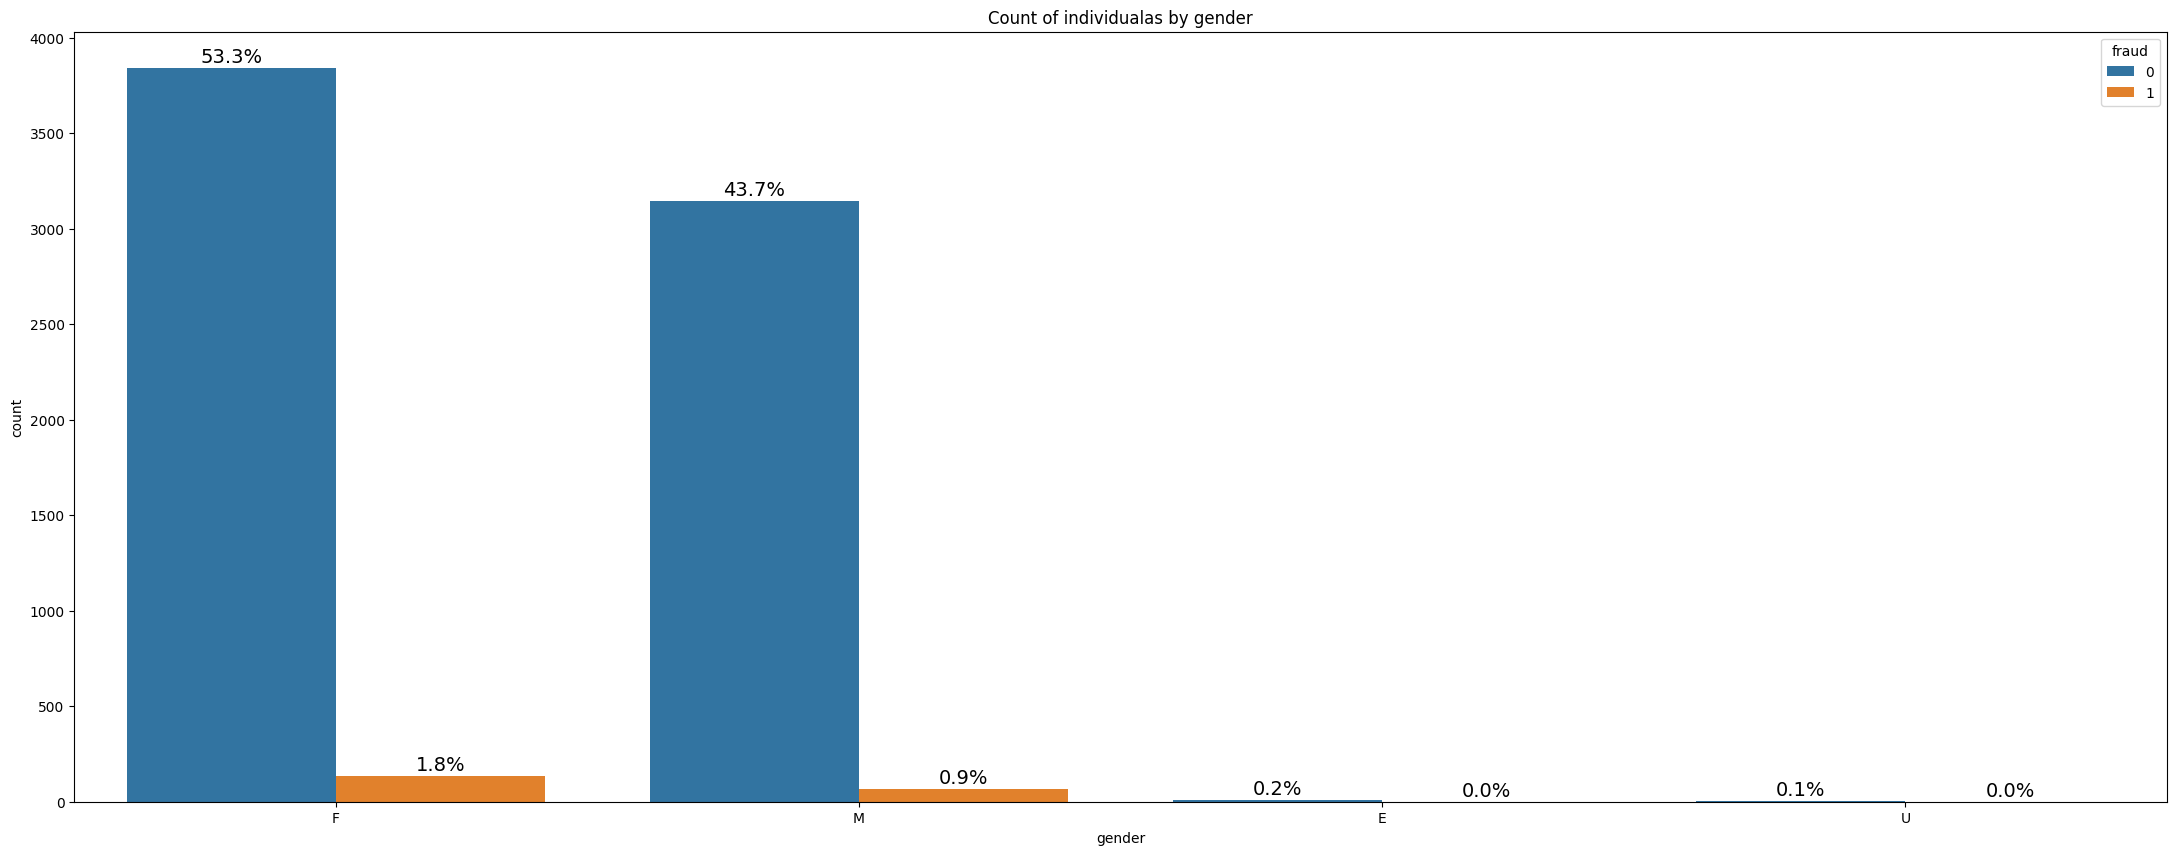

In [16]:
total = len(df)
fig, axes = plt.subplots(1,1,figsize=(27,10))
sns.countplot(x='gender', hue='fraud',data=df)
axes.set(title="Count of individualas by gender",xlabel="gender")
for p in axes.patches:
    percentage=f'{100*p.get_height()/total:.1f}%\n'
    x=p.get_x()+p.get_width()/2
    y=p.get_height()
    axes.annotate(percentage,(x,y),ha='center',va='center',fontsize=14)


Now, by age in the company:

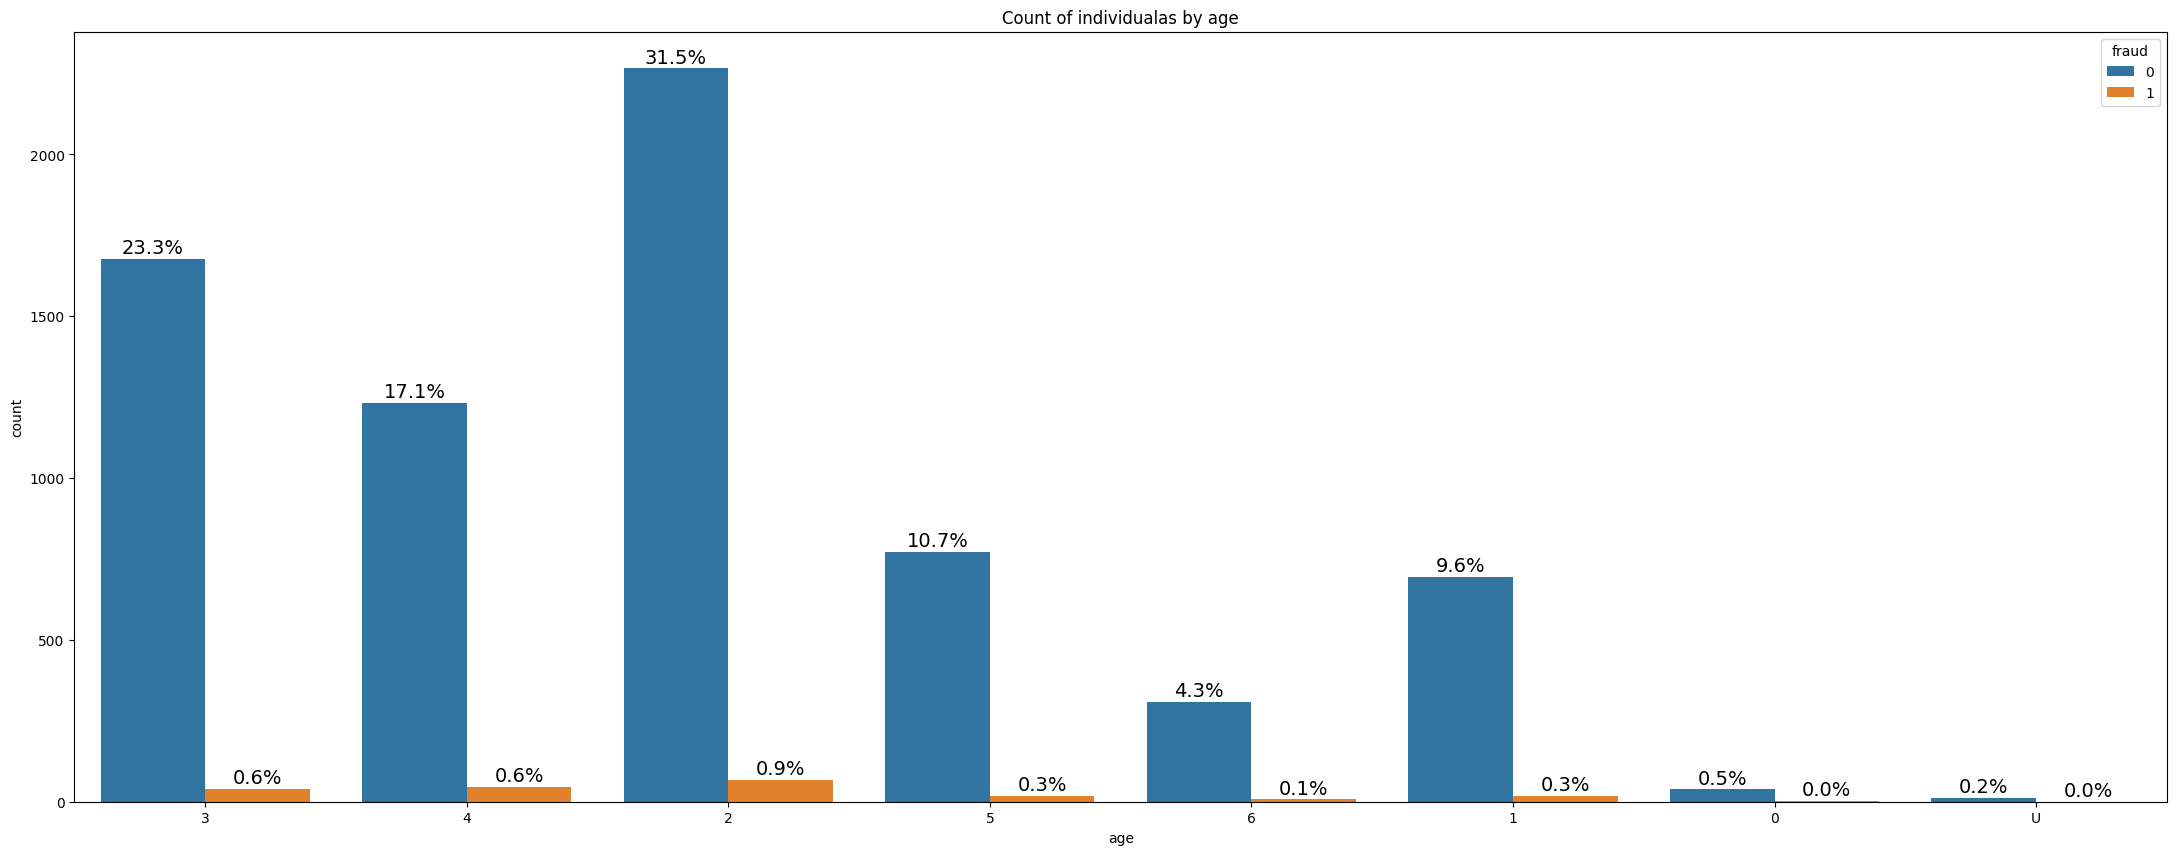

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
total = len(df)
fig, axes = plt.subplots(1,1,figsize=(27,10))
sns.countplot(x='age', hue='fraud',data=df)
axes.set(title="Count of individualas by age", xlabel="age")
for p in axes.patches:
    percentage=f'{100*p.get_height()/total:.1f}%\n'
    x=p.get_x()+p.get_width()/2
    y=p.get_height()
    axes.annotate(percentage,(x,y),ha='center',va='center',fontsize=14)

And finally by inspecting the amount:

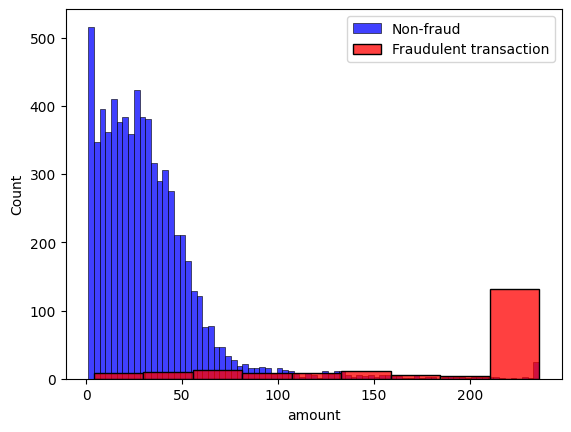

In [56]:
sns.histplot(df.loc[df['fraud']==0]['amount'], color='blue', label='Non-fraud',common_norm=False)
sns.histplot(df.loc[df['fraud']==1]['amount'], color='red', label='Fraudulent transaction',common_norm=False)
plt.legend()
plt.show()

We observe that the transactions with higher than $200 tend to be more fraudulent. Moreover, the fraudulent transactions tend to be on the larger side relative to normal obervations. This is good news, as it helps us later in detecting fraud from non-fraud.

## Unsupervised ML model:
### K-Means clustering

For ML algorithms using distance based metrics, it is crucial to always scale your data, as features using different scales will distort your results. K-means uses the Euclidian distance to assess distance to cluster centroids.  

We use the class MiniBatchKMeans from sklearn.cluster and tuned the hyperparameters n_clusters, 
max_iter, and batch_sizeby using optuna, where we minimize the inertia to obtain thus the best hyperparameters.

In [19]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder 
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import optuna

X = df.loc[:,~df.columns.isin(['Unnamed: 0', 'fraud'])]
y = df["fraud"]
categorical_features = ["age","gender","category"]
numerical_features = ["amount"]

# Pipeline for preprocessing the numerical data
numerical_transformer =  Pipeline(steps=[('imp_num',
                                          SimpleImputer(strategy='median')),
                                         ('sc',MinMaxScaler())])

# Pipeline for preprocessing the categorical data
categorical_transformer=Pipeline(steps=[('imp_cat',
                                         SimpleImputer(strategy='most_frequent')),
                                        ('onehot',
                                         OneHotEncoder(handle_unknown = 'ignore'))])

# Preprocessor
preprocessor = ColumnTransformer(transformers=[('num',numerical_transformer,
                                                numerical_features),
                                               ('cat', categorical_transformer,
                                                categorical_features)])

# The model
kmeans_pipeline = Pipeline(steps=[("preprocess",preprocessor),("kmeans",MiniBatchKMeans(random_state=42))])

def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    max_iter = trial.suggest_int("max_iter", 100, 500)
    batch_size = trial.suggest_int("batch_size", 100, 1000)

    kmeans_pipeline.set_params(kmeans__n_clusters=n_clusters,
                               kmeans__max_iter=max_iter,
                               kmeans__batch_size=batch_size)

    kmeans_pipeline.fit(X)

    labels = kmeans_pipeline.named_steps['kmeans'].labels_
    
    inertia = kmeans_pipeline.named_steps['kmeans'].inertia_

    return inertia

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2023-08-01 23:37:54,286] A new study created in memory with name: no-name-14348202-477b-48a3-a4d6-927fc4d04034
C:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[I 2023-08-01 23:37:54,520] Trial 0 finished with value: 5661.400245142673 and parameters: {'n_clusters': 5, 'max_iter': 237, 'batch_size': 142}. Best is trial 0 with value: 5661.400245142673.
C:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[I 2023-08-01 23:37:54,857] Trial 1 finished with value: 3232.742212406472 and parameters: {'n_clusters': 10, 'max_iter': 378, 'batch_size': 824}. Best is trial 1 with value: 3232.742212406472.
C:\Users\cmuro\anaconda3\lib\

Therefore, the best hyperparameters found are:

In [20]:
study.best_params

{'n_clusters': 10, 'max_iter': 496, 'batch_size': 661}

Now going to use the K-means algorithm to predict fraud, and compare those predictions to the actual labels that we saved, to sense check our results.

The fraudulent transactions are typically flagged as the observations that are furthest aways from the cluster centroid. We select the points that are in the top 5th percentile in distance from the cluster centroids.  

In [39]:
preprocessor = kmeans_pipeline.named_steps['preprocess']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, stratify=y)

kmeans_pipeline = Pipeline(steps=[("preprocess",preprocessor),
                                  ("kmeans",MiniBatchKMeans(**study.best_params,random_state=42))])

X_test_numeric= (kmeans_pipeline.named_steps['preprocess'].transform(X_test)).astype(float)

kmeans_model = kmeans_pipeline.fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans_model.predict(X_test)
X_test_clusters_centers = kmeans_model.named_steps['kmeans'].cluster_centers_

X_test_numeric_dense = X_test_numeric.toarray()

dist = [np.linalg.norm(x-y) for x, y in zip(X_test_numeric_dense, X_test_clusters_centers[X_test_clusters])]

km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

C:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [49]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, silhouette_score
print(f"Our roc_score of our model is: {roc_auc_score(y_test, km_y_pred)}")

Our roc_score of our model is: 0.8651428571428572


Moreover, the confusion matrix and classification report are:

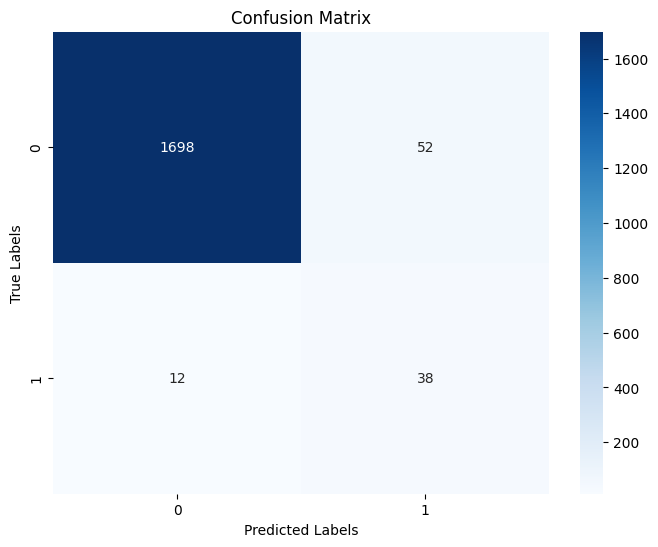

In [47]:
km_cm = confusion_matrix(y_test, km_y_pred)
labels = sorted(set(y_test))
plt.figure(figsize=(8, 6))
sns.heatmap(km_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
print(classification_report(y_test, km_y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1750
           1       0.42      0.76      0.54        50

    accuracy                           0.96      1800
   macro avg       0.71      0.87      0.76      1800
weighted avg       0.98      0.96      0.97      1800



## DBSCAN

Now, let us use density based clustering method (DBSCAN) to detect fraud.  

The advantage of DBSCAN is that we do not need to define the number of clusters beforehand. Also, DBSCAN can handle weirdly shaped data (i.e. non-convex) much better than K-means can.  
  
Initialize a DBSCAN model setting the maximum distance between two samples to 0.9 and the minimum observations in the clusters to 10.    
      
This time, we're not going to take the outliers of the clusters and use that for fraud, but take the smallest clusters in the data and label those as fraud. 

In [64]:
from sklearn.cluster import DBSCAN

X_scaled = (kmeans_pipeline.named_steps['preprocess'].transform(X)).toarray()
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(kmeans_pipeline.named_steps['preprocess'].transform(X))

pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters)
print("The Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))

Estimated number of clusters: 54
The Silhouette Coefficient: 0.860


Since our Silhouette coefficient is close to 1, we got a model with good grouping.

## Conclusions 

* For the kmeans, we found throuhg optuna minimizing the inertia, that best model should has the parameters 'n_clusters': 10, 'max_iter': 496, 'batch_size': 661. The area under roc curve has a value of 0.86.  

* Using a dbscan model we got a Silhouette Coefficient of 0.860. 